## Stock Price Prediction Model
### COSC 325 Course Project Fall 2024
John Paul Saia<Br>
Riley Taylor<Br>
Shanna Wallace

In [83]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score


### Load and Prepare the Data
* Read in the CSV file of Bershire Hathaway stock price data
* Clean the data
* Extract features and target:
    * Target: 
        * Closing price ('Close')
    * Features: 
        * Date ('Date')
        * Opening Price ('Open')
        * Highest Price ('High')
        * Lowest Price ('Low')
        * Volume ('Volume')

In [134]:
RANDOM_STATE = 42

file = "./berkshire_hathaway_data.csv"
stock_data = pd.read_csv(file)

# Clean by removing all rows with missing values:
stock_data = stock_data.dropna().reset_index(drop = True)
stock_data.head()


features = ["Open", "High", "Low", "Volume"]

y = stock_data['Close']
X = stock_data[features]

# Separate data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)



### Create simple baseline model
Linear Regression model using features:
* Open
* High
* Low

Data Spilt: 
* 80% Training / 20% Testing

In [131]:
# Create the simple Model
simple_X_train = X_train
simple_X_test = X_test
simple_model = LinearRegression()
simple_model.fit(simple_X_train, y_train)
simple_test_predictions = simple_model.predict(simple_X_test)

# Calculate the mean of the predictions (expected prediction)
simple_mean_prediction = np.mean(simple_test_predictions)

# Calculate bias, variance, and Root Mean Squared Error (RMSE) on the test set
simple_bias = np.mean((y_test - simple_mean_prediction) ** 2)
simple_variance = np.mean((simple_test_predictions - simple_mean_prediction) ** 2)
simple_rmse = root_mean_squared_error(y_test, simple_test_predictions)

print(f"Simple Model:\n  Bias: {simple_bias:,.2f}\n  Variance: {simple_variance:,.2f}\n  RMSE: {simple_rmse:,.2f}")


Simple Model:
  Bias: 5,673.63
  Variance: 5,669.07
  RMSE: 0.93


### Create Complex Model with Polynomial Expansion
Test degree values 1 through 10 and calculate R2 and RMSE for each to determine the best degree to use for the complex model


Degree with maximum R2: 1 with 0.9998
Degree with minimum RMSE: 1 with 0.93


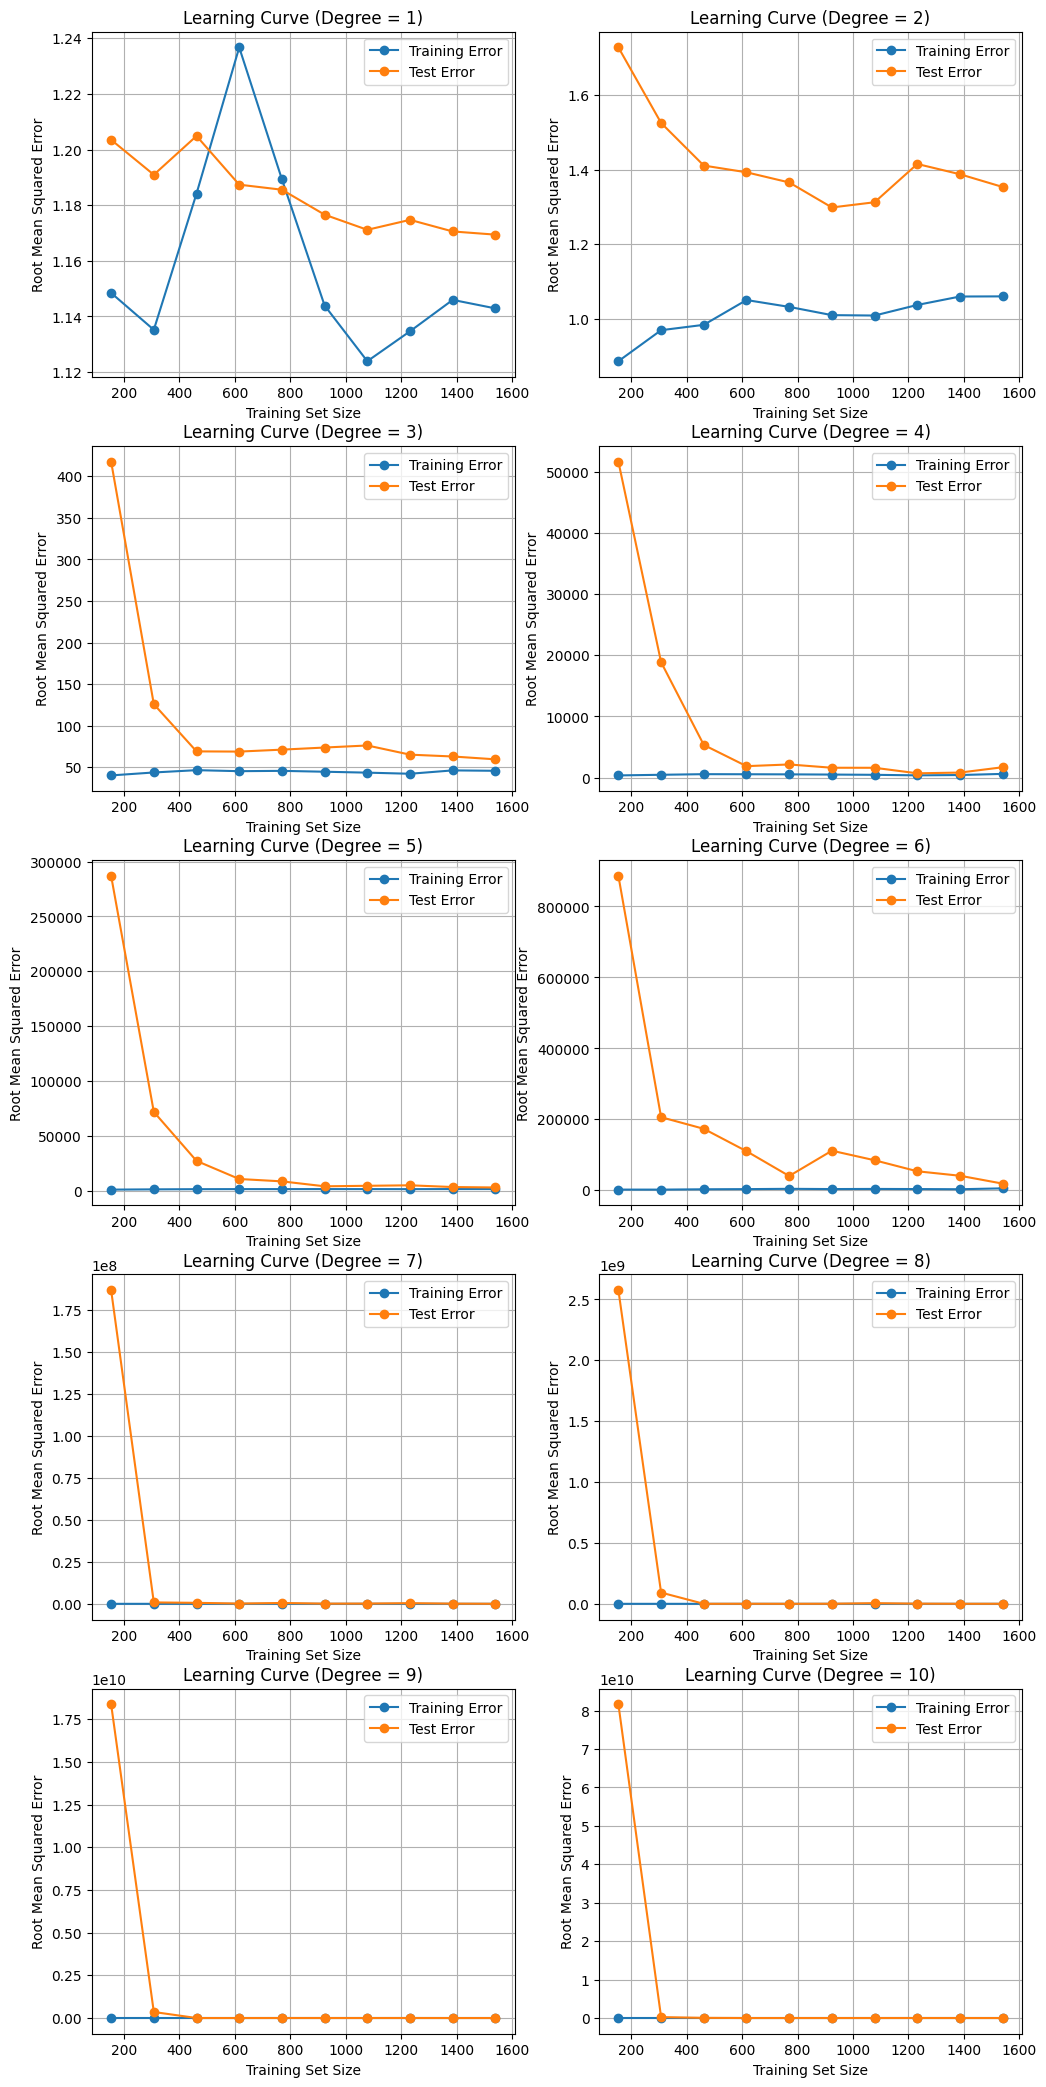

In [132]:
rmse_results = [0] * 10
r2_results = [0] * 10

fig, axes = plt.subplots(5, 2, figsize=(12, 26))
# row for the subplot
r = -1

# Define a function for plotting the learning curve
for degree in range(1, 11):
    # Complex Model: Using the features with Polynomial Expansion
    poly = PolynomialFeatures(degree=degree)

    # Transform the training and test data
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Initialize the linear regression model
    poly_model = LinearRegression()


    # Calculate learning curves for the polynomial model
    train_sizes, train_scores, test_scores = learning_curve(
        poly_model, X_train_poly, y_train, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=RANDOM_STATE
    )

    # Calculate mean error
    train_errors = -np.mean(train_scores, axis=1)
    test_errors = -np.mean(test_scores, axis=1)

    # set row and column for the subplot
    if (degree-1) % 2 == 0:
        r+=1
    c = (degree-1) % 2

    # Plot learning curves
    axes[r,c].plot(train_sizes, train_errors, label='Training Error', marker='o')
    axes[r,c].plot(train_sizes, test_errors, label='Test Error', marker='o')
    axes[r,c].set_title(f'Learning Curve (Degree = {degree})')
    axes[r,c].set_xlabel('Training Set Size')
    axes[r,c].set_ylabel('Root Mean Squared Error')
    axes[r,c].legend()
    axes[r,c].grid(True)


    # Fit the model and predict
    poly_model.fit(X_train_poly, y_train)
    complex_test_predictions = poly_model.predict(X_test_poly)

    # Calculate the mean of the predictions (expected prediction)
    complex_mean_prediction = np.mean(complex_test_predictions)

    # Calculate bias
    complex_bias = np.mean((y_test - complex_mean_prediction) ** 2)

    # Calculate variance
    complex_variance = np.mean((complex_test_predictions - complex_mean_prediction) ** 2)

    # Calculate the Root Mean Squared Error (MSE) on the Test set
    rmse_results[degree - 1] = root_mean_squared_error(y_test, complex_test_predictions)
    r2_results[degree - 1] = r2_score(y_test, complex_test_predictions)
    
# Want to minimize errors and maximize R2
max_r2 = max(r2_results)
min_rmse = min(rmse_results)
print(f"\nDegree with maximum R2: {r2_results.index(max_r2) + 1} with {max_r2:,.4f}")
print(f"Degree with minimum RMSE: {rmse_results.index(min_rmse) + 1} with {min_rmse:,.2f}")